# National Mental Health Datahton

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import re
import os
import io
from io import BytesIO
import difflib
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from contextlib import redirect_stdout
import tqdm
from datetime import datetime
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from textblob import TextBlob
from typing import Tuple, Dict, Any
import pyspssio
import folium
from folium.plugins import HeatMap
import json
import requests

## Utilities

#### Capture Print

In [2]:
# Function to capture print outputs
def capture_print(func, filename):
    f = io.StringIO()
    with redirect_stdout(f):
        func()
    output = f.getvalue()
    if output.strip(): 
        with open(f'text_outputs/{filename}.txt', 'w') as file:
            file.write(output)

#### Load Data

In [3]:
# Load the Guarding Minds .SAV file
file_path = 'input/Mental Health Research Canada/Guarding Minds - Mental Health in the Workplace/Guarding minds 2023_weighted_15.6.2023 Final.sav'
df, meta = pyspssio.read_sav(file_path)

print(df.head())

   record  QLANG  SCR1  AGEGROUP  QST_AGE  SCR2  SCR3  SCR3A  SCR4 SCR5  ...  \
0     1.0    2.0  31.0       2.0      2.0   1.0   1.0    4.0   2.0  H2R  ...   
1     2.0    1.0  32.0       2.0      2.0   1.0   1.0    4.0   2.0  V7C  ...   
2     3.0    1.0  59.0       4.0      4.0   1.0   1.0    2.0   2.0  M1K  ...   
3     4.0    2.0  25.0       1.0      1.0   2.0   1.0   96.0   1.0  J7G  ...   
4     5.0    1.0  58.0       4.0      4.0   2.0   1.0    4.0   2.0  S4X  ...   

   BAN_SCR7  BAN_SCR12r1  BAN_SCR12r2  BAN_SCR12r3  BAN_SCR13  REG_GEN_AGE  \
0       1.0          1.0          0.0          0.0        2.0         68.0   
1       2.0          0.0          0.0          1.0        2.0          8.0   
2       1.0          1.0          1.0          0.0        2.0         59.0   
3       1.0          0.0          0.0          1.0        2.0         62.0   
4       1.0          1.0          1.0          0.0        1.0         29.0   

         WT  SCR6_EMPLOYMENT  SCR8_WORK_SITUATION 

In [4]:
# Basic dataset information
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")

# Display column names
print("\nColumn names:")
print(df.columns.tolist())

# Display data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset shape: (5505, 258)
Number of rows: 5505, Number of columns: 258

Column names:
['record', 'QLANG', 'SCR1', 'AGEGROUP', 'QST_AGE', 'SCR2', 'SCR3', 'SCR3A', 'SCR4', 'SCR5', 'PROV', 'SCR6r1', 'SCR6r2', 'SCR6r3', 'SCR6r4', 'SCR6r5', 'SCR6r6', 'SCR6r7', 'SCR6r8', 'SCR6r9', 'SCR6r10', 'SCR6r11', 'SCR6r12', 'SCR6r13', 'SCR7', 'SCR8r1', 'SCR8r2', 'SCR8r3', 'SCR8r4', 'SCR8r5', 'SCR8r6', 'SCR8r7', 'SCR8r8', 'SCR8r9', 'SCR8r10', 'SCR8r11', 'SCR8r12', 'SCR8r13', 'SCR8r14', 'SCR8r15', 'SCR8r16', 'SCR8r17', 'SCR8r18', 'SCR8r19', 'SCR9', 'SCR9_1', 'SCR9_2', 'SCR9_3', 'SCR9_4', 'SCR10r1', 'SCR10r5', 'SCR10r6', 'SCR10r7', 'SCR10r8', 'SCR10r9', 'SCR10r10', 'SCR10r11', 'SCR10r12', 'SCR10r99', 'SCR10Ar1', 'SCR10Ar2', 'SCR10Ar3', 'SCR10Ar4', 'SCR10Ar5', 'SCR10Ar6', 'SCR10Ar7', 'SCR10Ar8', 'SCR10Ar9', 'SCR10Ar10', 'SCR10Ar11', 'SCR10Ar99', 'SCR11', 'SCR12r1', 'SCR12r2', 'SCR12r3', 'SCR13', 'SCR14', 'SCR15', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15

In [5]:
# Function to explore and apply SPSS metadata
def process_spss_metadata(df, meta):
    print(f"Dataset has {len(df.columns)} variables")
    
    # 1. Create a data dictionary
    var_info = []
    for col in df.columns:
        info = {
            'variable': col,
            'label': meta.get('var_labels', {}).get(col, ''),
            'values': meta.get('var_value_labels', {}).get(col, {}),
            'type': meta.get('var_types', {}).get(col, ''),
            'measure': meta.get('var_measure_levels', {}).get(col, '')
        }
        var_info.append(info)
    
    data_dict = pd.DataFrame(var_info)
    
    # 2. Create versions of the DataFrame
    # Original with variable attributes
    for col in df.columns:
        if col in meta.get('var_labels', {}):
            df[col].attrs['label'] = meta['var_labels'][col]
        if col in meta.get('var_value_labels', {}):
            df[col].attrs['value_labels'] = meta['var_value_labels'][col]
    
    # Version with readable column names
    labeled_columns_df = df.copy()
    labeled_columns_df.columns = [meta.get('var_labels', {}).get(col, col) for col in df.columns]
    
    # Version with values replaced by labels - UPDATED APPROACH
    labeled_values_df = df.copy()
    for col, labels in meta.get('var_value_labels', {}).items():
        if col in labeled_values_df.columns:
            # Using apply with lambda instead of map+fillna
            labeled_values_df[col] = labeled_values_df[col].apply(
                lambda x: labels.get(x, x) if pd.notna(x) else x
            )
    
    return {
        'original': df,
        'data_dictionary': data_dict,
        'labeled_columns': labeled_columns_df,
        'labeled_values': labeled_values_df
    }

# Apply the function to your data
results = process_spss_metadata(df, meta)

# Extract each component into separate variables for easier access
original_df = results['original']  # Original DataFrame with attributes
data_dictionary = results['data_dictionary']  # Data dictionary with variable info
labeled_columns_df = results['labeled_columns']  # DataFrame with human-readable column names
labeled_values_df = results['labeled_values']  # DataFrame with human-readable values

Dataset has 258 variables


In [6]:
# Display information about each component
print("\n=== Original DataFrame ===")
print(f"Shape: {original_df.shape}")
print(original_df.head())

print("\n=== Data Dictionary ===")
print(f"Number of variables: {len(data_dictionary)}")
print(data_dictionary.head())

print("\n=== DataFrame with Labeled Columns ===")
print(f"Shape: {labeled_columns_df.shape}")
print(labeled_columns_df.head())

print("\n=== DataFrame with Labeled Values ===")
print(f"Shape: {labeled_values_df.shape}")
print(labeled_values_df.head())


=== Original DataFrame ===
Shape: (5505, 258)
   record  QLANG  SCR1  AGEGROUP  QST_AGE  SCR2  SCR3  SCR3A  SCR4 SCR5  ...  \
0     1.0    2.0  31.0       2.0      2.0   1.0   1.0    4.0   2.0  H2R  ...   
1     2.0    1.0  32.0       2.0      2.0   1.0   1.0    4.0   2.0  V7C  ...   
2     3.0    1.0  59.0       4.0      4.0   1.0   1.0    2.0   2.0  M1K  ...   
3     4.0    2.0  25.0       1.0      1.0   2.0   1.0   96.0   1.0  J7G  ...   
4     5.0    1.0  58.0       4.0      4.0   2.0   1.0    4.0   2.0  S4X  ...   

   BAN_SCR7  BAN_SCR12r1  BAN_SCR12r2  BAN_SCR12r3  BAN_SCR13  REG_GEN_AGE  \
0       1.0          1.0          0.0          0.0        2.0         68.0   
1       2.0          0.0          0.0          1.0        2.0          8.0   
2       1.0          1.0          1.0          0.0        2.0         59.0   
3       1.0          0.0          0.0          1.0        2.0         62.0   
4       1.0          1.0          1.0          0.0        1.0         29.0   

   

In [7]:
# List all columns and save column names along with their data types to csv
def save_column_names_to_csv(df, df_type):
    filename = f"text_outputs/guarding_minds/{df_type}_survey_columns.csv"
    
    # Create a DataFrame with the column names and their data types
    column_info = pd.DataFrame({
        'Column Names': df.columns,
        'Data Type': [df.dtypes[col] for col in df.columns]
    })
    
    # Save to CSV
    column_info.to_csv(filename, index=False)
    print(f"\nColumn names and data types have been saved to {filename}")
    
save_column_names_to_csv(df, 'original')
save_column_names_to_csv(labeled_columns_df, 'labeled_columns')
save_column_names_to_csv(labeled_values_df, 'labeled_values')


Column names and data types have been saved to text_outputs/guarding_minds/original_survey_columns.csv

Column names and data types have been saved to text_outputs/guarding_minds/labeled_columns_survey_columns.csv

Column names and data types have been saved to text_outputs/guarding_minds/labeled_values_survey_columns.csv


In [8]:
# Save your processed data for future use
original_df.to_pickle('processed_data/guarding_minds/original_df.pkl')
data_dictionary.to_csv('processed_data/guarding_minds/data_dictionary.csv', index=False)
labeled_columns_df.to_pickle('processed_data/guarding_minds/labeled_columns_df.pkl')
labeled_values_df.to_pickle('processed_data/guarding_minds/labeled_values_df.pkl')

print("\nAll processed datasets have been saved to the 'processed_data' folder.")


All processed datasets have been saved to the 'processed_data' folder.


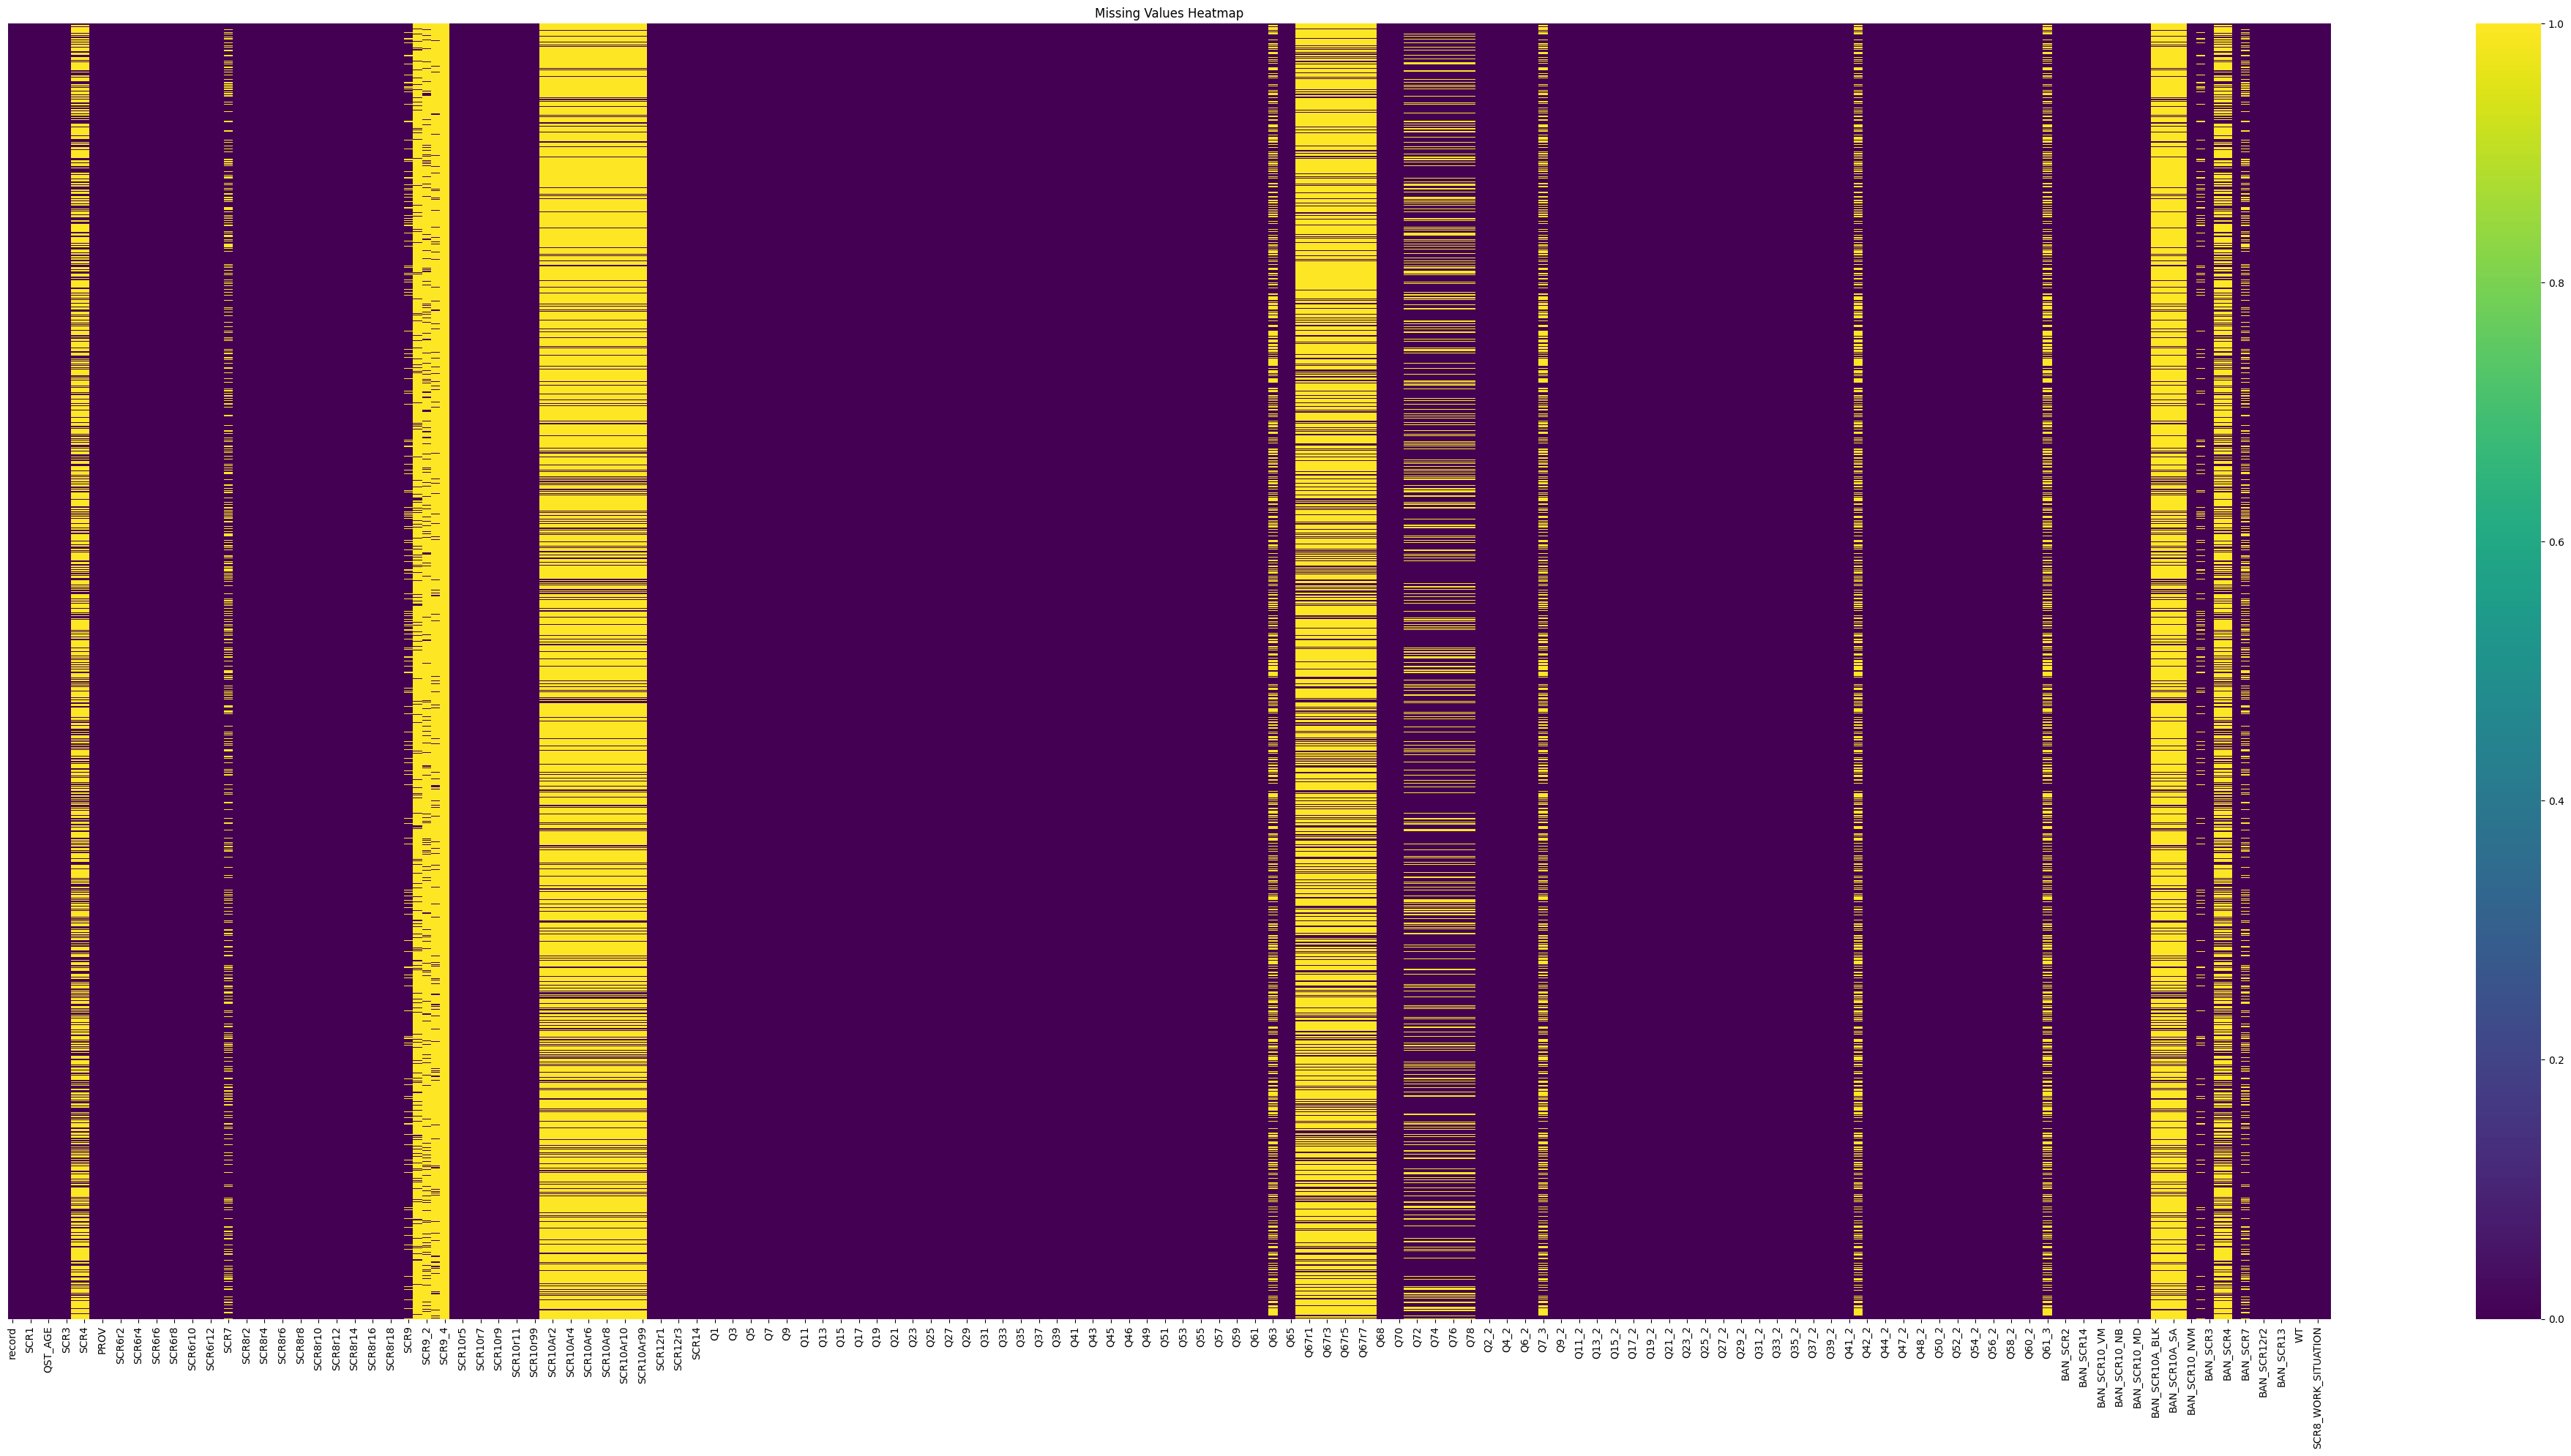

In [9]:
# set specific guarding minds output path
output_path = 'plot_outputs/guarding_minds'

# missing values heatmap
def plot_missing_values_heatmap(df, output_path):
    plt.figure(figsize=(40, 20))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig(f'{output_path}/missing_values_heatmap.png')
    plt.show()
    plt.close()

plot_missing_values_heatmap(labeled_values_df, output_path)

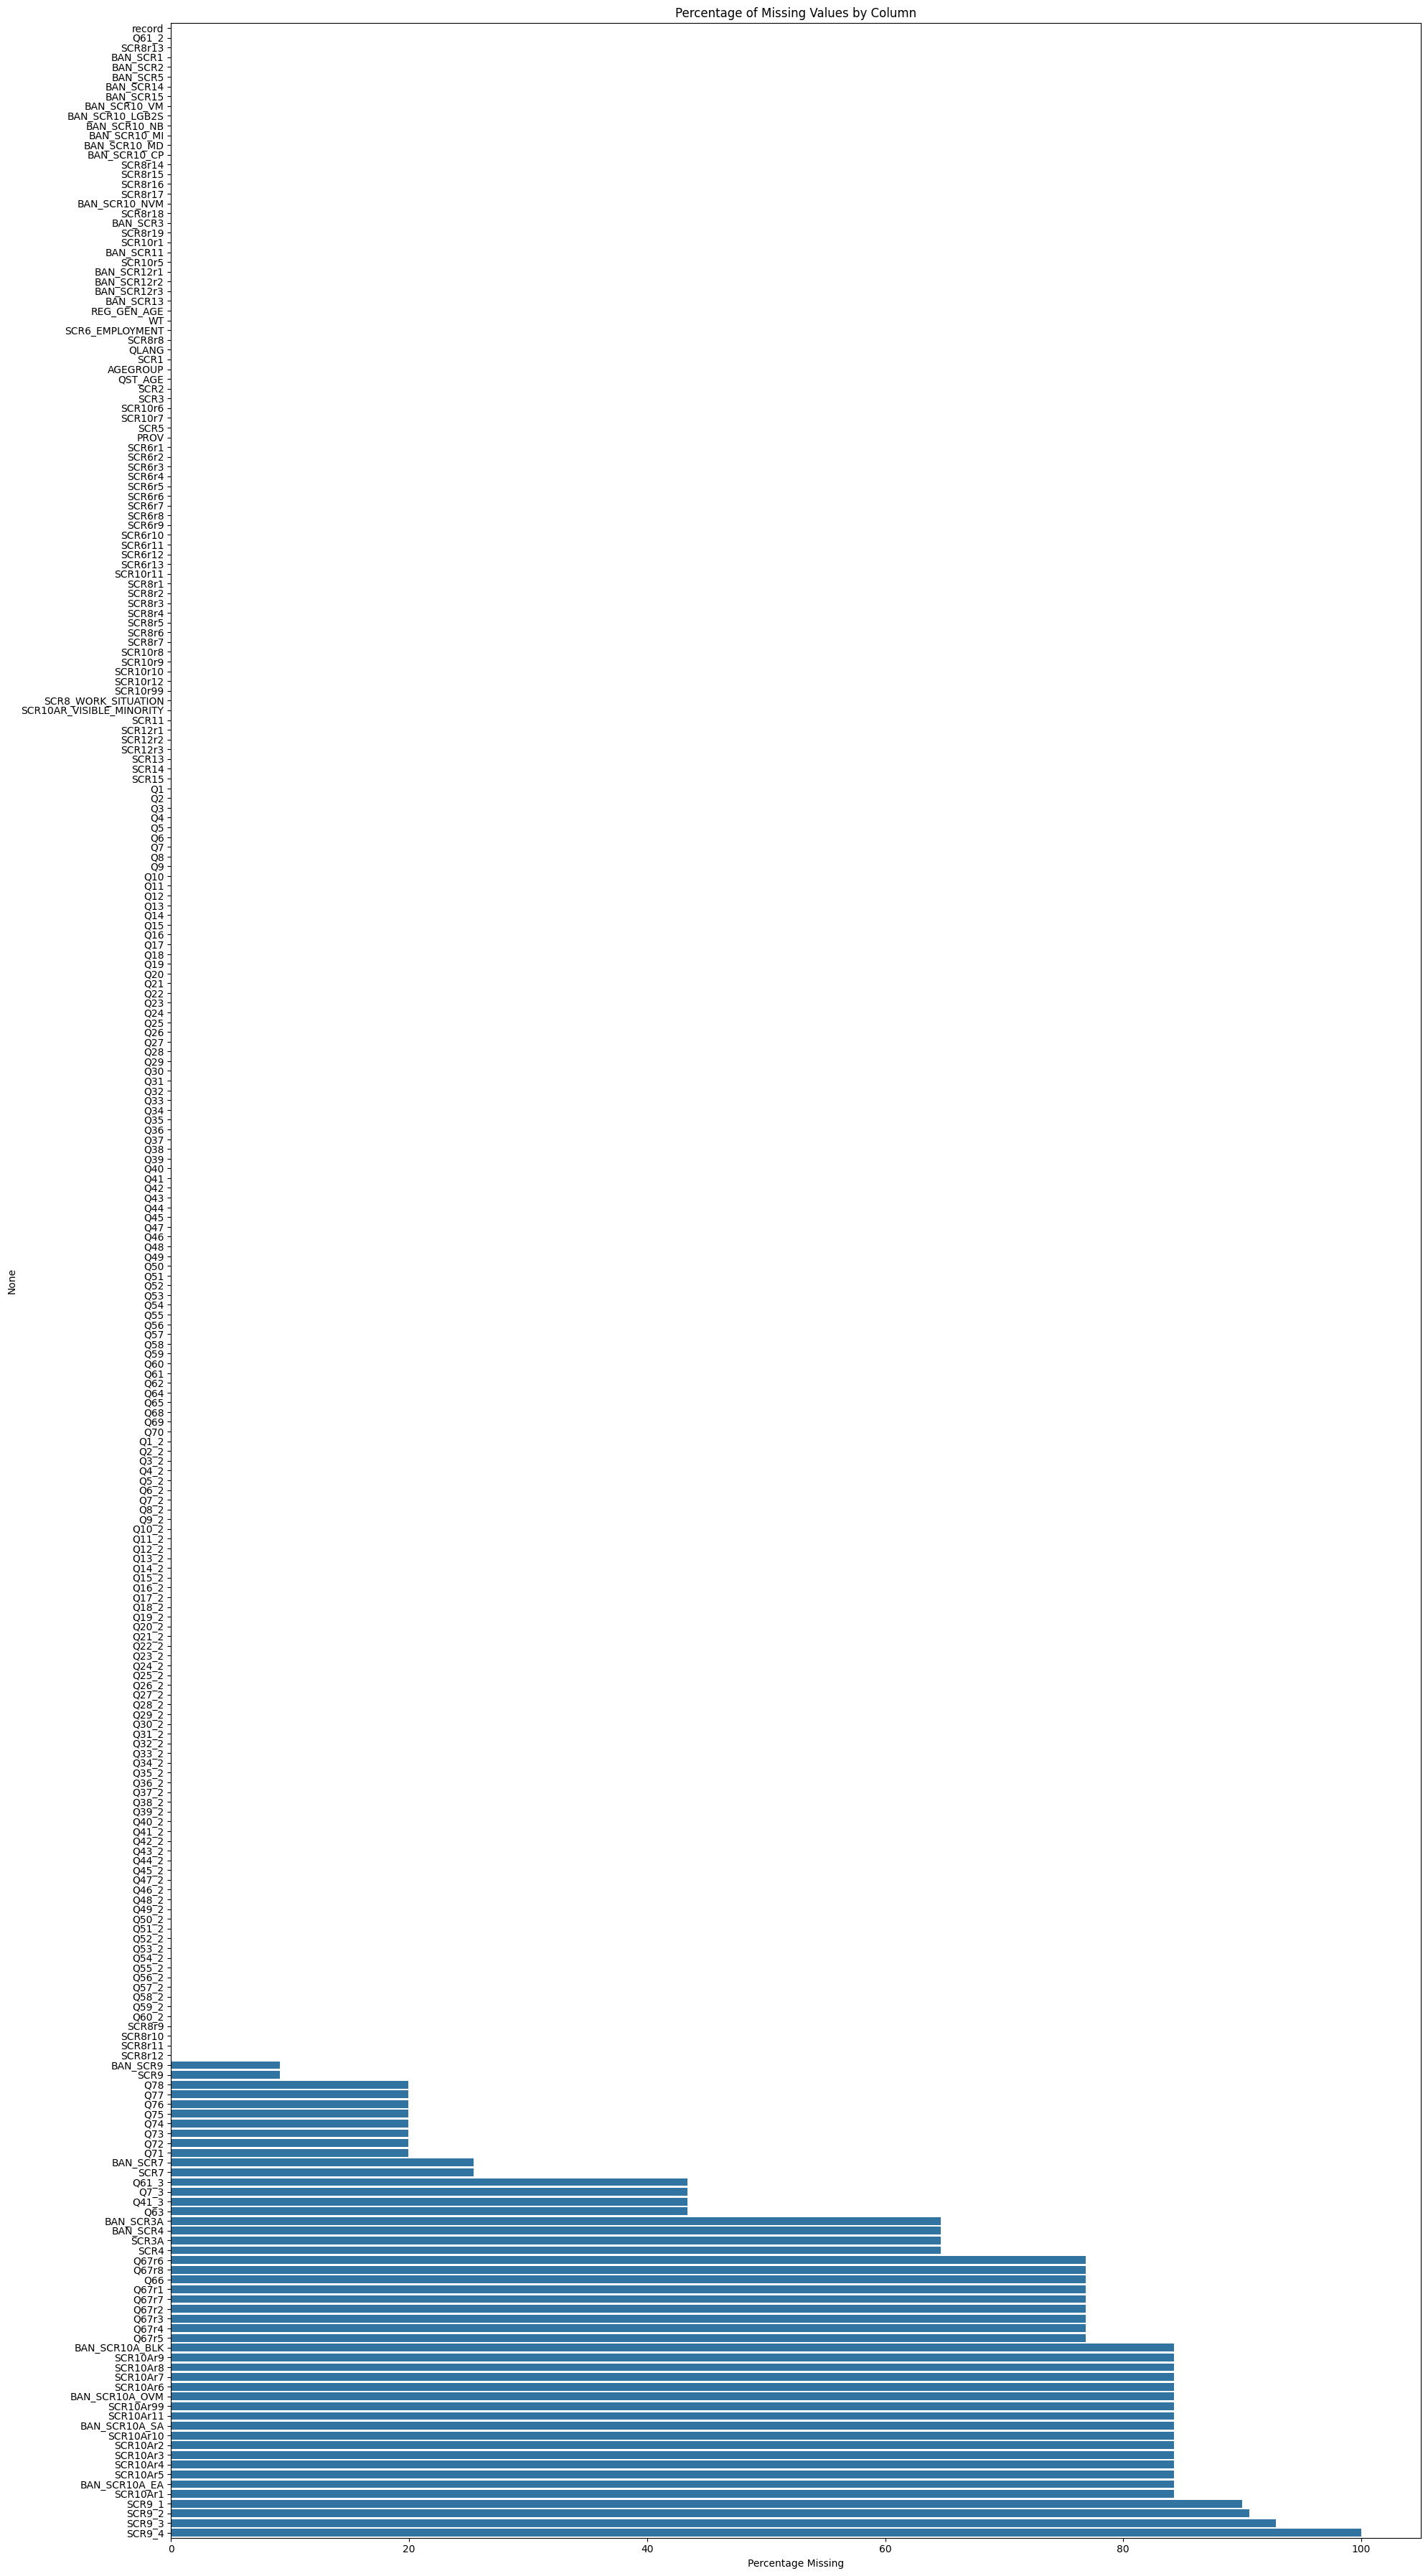

In [10]:
# missing value percentages
def plot_missing_values_bars(df, output_path):
    plt.figure(figsize=(20, 36))
    missing_percentages = (df.isnull().sum() / len(df) * 100).sort_values(ascending=True)
    sns.barplot(x=missing_percentages.values, y=missing_percentages.index)
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Percentage Missing')
    plt.tight_layout()
    plt.savefig(f'{output_path}/missing_values_percentage.png')
    plt.show()
    plt.close()

plot_missing_values_bars(labeled_values_df, output_path)

In [11]:
# Replace NaN with 'Missing' for every object column and convert to category type
labeled_values_df_columns = labeled_values_df.columns

for c in labeled_values_df_columns:
    if labeled_values_df[c].dtype == "object":
        # Step 1: Replace NaN values with 'Missing'
        labeled_values_df[c] = labeled_values_df[c].fillna("Missing")
        
        # Step 2: Convert the column from object type to category type
        labeled_values_df[c] = labeled_values_df[c].astype('category')
        
        # Optional: Print conversion confirmation for debugging
        print(f"Column '{c}' converted to category with dtype: {labeled_values_df[c].dtype}")

# Print summary of categorical features
print(f"In these features, there are {len(labeled_values_df_columns)} CATEGORICAL FEATURES: {labeled_values_df_columns}")

# Optional: Print memory usage improvement
print(f"Memory usage after conversion: {labeled_values_df.memory_usage().sum() / 1024**2:.2f} MB")

Column 'QLANG' converted to category with dtype: category
Column 'AGEGROUP' converted to category with dtype: category
Column 'QST_AGE' converted to category with dtype: category
Column 'SCR2' converted to category with dtype: category
Column 'SCR3' converted to category with dtype: category
Column 'SCR3A' converted to category with dtype: category
Column 'SCR4' converted to category with dtype: category
Column 'SCR5' converted to category with dtype: category
Column 'PROV' converted to category with dtype: category
Column 'SCR6r1' converted to category with dtype: category
Column 'SCR6r2' converted to category with dtype: category
Column 'SCR6r3' converted to category with dtype: category
Column 'SCR6r4' converted to category with dtype: category
Column 'SCR6r5' converted to category with dtype: category
Column 'SCR6r6' converted to category with dtype: category
Column 'SCR6r7' converted to category with dtype: category
Column 'SCR6r8' converted to category with dtype: category
Column

In [12]:
# plot categorical distributions
def plot_categorical_distributions(df, output_path):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in tqdm.tqdm(categorical_cols, desc="Creating categorical plots"):
        if df[col].nunique() < 30:
            plt.figure(figsize=(10, 6))
            value_counts = df[col].value_counts()
            sns.barplot(x=value_counts.index, y=value_counts.values)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(f'{output_path}/categorical_{col}.png')
            plt.close()

# labeled values data frame
plot_categorical_distributions(labeled_values_df, output_path)

Creating categorical plots:  10%|▉         | 25/254 [00:02<00:20, 11.37it/s]C:\Users\RyanClarke\AppData\Local\Temp\ipykernel_51660\1809286863.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
Creating categorical plots: 100%|██████████| 254/254 [00:25<00:00,  9.77it/s]


In [13]:
# numerical distributions
def plot_numerical_distributions(df, output_path):
    numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
    
    # Create progress bar for numerical distributions
    for col in tqdm.tqdm(numerical_cols, desc="Creating distribution plots"):
        plt.figure(figsize=(10, 6))
        
        # Create subplot with histogram and kde
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        
        # Add statistical annotations
        stats_text = f'Mean: {df[col].mean():.2f}\n'
        stats_text += f'Median: {df[col].median():.2f}\n'
        stats_text += f'Std: {df[col].std():.2f}'
        plt.text(0.95, 0.95, stats_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f'{output_path}/distribution_{col}.png')
        plt.close()

# numerical distributions of labeled values
plot_numerical_distributions(labeled_values_df, output_path)

# numerical distributions of original
plot_numerical_distributions(df, output_path)

Creating distribution plots:  50%|█████     | 2/4 [00:00<00:00,  5.30it/s]c:\Users\RyanClarke\repos\NMHD\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
Creating distribution plots:  18%|█▊        | 47/256 [00:08<00:33,  6.30it/s]c:\Users\RyanClarke\repos\NMHD\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
Creating distribution plots: 100%|██████████| 256/256 [00:46<00:00,  5.49it/s]


In [14]:
# Count occurrences of each province
province_counts = labeled_values_df['PROV'].value_counts().reset_index()
province_counts.columns = ['province_code', 'count']

# Print the counts to verify
print("Province counts:")
print(province_counts)

Province counts:
          province_code  count
0               Ontario   2092
1                Quebec   1335
2      British Columbia    686
3               Alberta    613
4              Manitoba    223
5          Saskatchewan    162
6           Nova Scotia    161
7         New Brunswick    127
8          Newfoundland     80
9  Prince Edward Island     26


In [15]:
# fix Newfoundland label
province_counts['province_code'] = province_counts['province_code'].astype(str)
province_counts.loc[province_counts['province_code'] == 'Newfoundland', 'province_code'] = 'Newfoundland and Labrador'
province_counts['province_code'] = province_counts['province_code'].astype('category')

In [16]:
# get canada geojson file
canada_geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/canada.geojson"
canada_geojson_response = requests.get(canada_geojson_url)
canada_geojson = json.loads(canada_geojson_response.content)

In [17]:
# create base map
canada_map = folium.Map(location=[56.1304, -106.3468], zoom_start=3, 
                       tiles='CartoDB positron')

# Add choropleth layer
choropleth = folium.Choropleth(
    geo_data=canada_geojson,
    name='choropleth',
    data=province_counts,
    columns=['province_code', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',  # Yellow-Orange-Red color scheme
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Number of occurrences in PROV column',
    highlight=True
).add_to(canada_map)

# Add tooltips to the choropleth layer
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'], labels=False)
)

# Add a layer control
folium.LayerControl().add_to(canada_map)

In [18]:
for _, row in province_counts.iterrows():
    # Find the matching province in the GeoJSON
    for feature in canada_geojson['features']:
        if feature['properties']['name'] == row['province_code']:
            # Get approximate center of the province
            geometry = feature['geometry']
            if geometry['type'] == 'Polygon':
                # For simple polygons
                coords = np.array(geometry['coordinates'][0])
                center = coords.mean(axis=0)
                # Folium expects coordinates as [lat, lon]
                center = [center[1], center[0]]
            elif geometry['type'] == 'MultiPolygon':
                # For complex shapes with multiple polygons
                all_coords = []
                for polygon in geometry['coordinates']:
                    coords = np.array(polygon[0])
                    all_coords.append(coords)
                all_coords = np.vstack(all_coords)
                center = all_coords.mean(axis=0)
                center = [center[1], center[0]]
            else:
                # Skip if geometry type is unexpected
                continue
                
            # Add a circle marker with count information
            folium.CircleMarker(
                location=center,
                radius=int(np.sqrt(row['count']) * 0.3),  # Scale the radius based on count
                popup=f"{row['province_code']}: {row['count']} occurrences",
                color='#3186cc',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7
            ).add_to(canada_map)

In [19]:
# Add a simple legend in the corner
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: auto; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white;
            padding: 10px;
            border-radius: 5px;
           ">
    <div style="font-weight: bold; margin-bottom: 5px;">Province Count Legend</div>
'''

# Add entries for each province in descending order
for _, row in province_counts.sort_values('count', ascending=False).iterrows():
    legend_html += f'<div>{row["province_code"]}: {row["count"]}</div>'

legend_html += '</div>'

# Add the legend as an HTML element
canada_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
canada_map.save('plot_outputs/guarding_minds/canada_province_heatmap.html')

In [20]:
canada_map